### Exploring Clustering with Online Retail data from UCI
MSDS 7331 Data Mining Lab 3

Authors: Laura Ludwig, Anthony Schams, Josh Balson, David Stroud

This is a trans-national data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The selection of attributes plays an important role in good clustering analysis. Therefore, we will cluster the RPM (Recency, Frequency, Monetary) variables using the Online Retail Data Set from the UCI Machine Learning Repository.

RPM analysis has historically been used to analyze large retail data sets of customer purchases to analyze retailer business activity. To accomplish this task, we will use clustering techniques to identify segments in the purchasing patterns to identify common characteristics. Since our data set is primarily composed of retailers purchasing from a wholesaler, it is in our best interest to identify the retailers purchasing patterns.

Market segmentation allows a business to analyze, understand and draw good market segements from the customers purchasing behavior. Clustering analysis will allow us to identify segments of retail purchases who have certain characteristics. Idenfication of these paterns give us an information advantage, thus allowing us to act on better solutions for our clients.

Once the data set has been properly cleaned, clustering intends to identify whether customers can be segmented meaningfully in the view of recency, frequency and monetary values. The k-means clustering algorithm was employed specifically for this purpose.

### Attribute Information:
 - InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
 - StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
 - Description: Product (item) name. Nominal.
 - Quantity: The quantities of each product (item) per transaction. Numeric.
 - InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
UnitPrice: Unit price. Numeric, Product price per unit in sterling.
 - CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
 - Country: Country name. Nominal, the name of the country where each customer res

In [2]:
import pandas as pd
import numpy as np

import time, warnings
import datetime as dt

#modules for predictive models
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GMM

from sklearn.metrics import silhouette_samples, silhouette_score

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")

In [3]:
#df = pd.read_excel('OnlineRetail.xlsx')
df = pd.read_csv('OnlineRetail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [4]:
df = df.loc[(~df['InvoiceNo'].str.startswith('C'))]

In [5]:
# Note that we have more than 540,000 instances
# and eight variables with the original dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532621 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      532621 non-null object
StockCode      532621 non-null object
Description    531167 non-null object
Quantity       532621 non-null int64
InvoiceDate    532621 non-null object
UnitPrice      532621 non-null float64
CustomerID     397924 non-null float64
Country        532621 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 36.6+ MB


RFM Score Calculations:
 - RECENCY (R): Days since last purchase
 - FREQUENCY (F): Total number of purchases
 - MONETARY VALUE (M): Total money this customer spent  
 
The purpose of uing the RFM analysis is to reduce the data set into attributes that may explain the business activities of the retailers.

In [6]:
# Note that we have 38 unique countries in date set# Note t 
df.Country.nunique()

38

In [7]:
# Breakdown of each unique country
df.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Finland',
       'Austria', 'Bahrain', 'Israel', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [8]:
# We have a total of 4,372 customer id's ~ 3,950 are from the United Kingdom
df.CustomerID.nunique()

4339

In [9]:
# List of Countries, by CustomerID in ascending order# List o 
customer_country=df[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
36,United Kingdom,3921
14,Germany,94
13,France,87
31,Spain,30
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,14
12,Finland,12
1,Austria,11


More than 90% of the customers are from the United Kingdom

In [10]:
# Restrict data set to the United Kingdom only# Restri 
df = df.loc[df['Country'] == 'United Kingdom']

### Missing Data
Notice that 133,600 values are missing from CustomerID. Since the analysis is based on customers, we will remove those with missing values. Thus, we are eliminating approximately twenty-five percent of the data set.

We are now down to 408,309 of the original 541,909 values

In [11]:
# Check whether there are missing values in each column
df.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133277
Country             0
dtype: int64

In [13]:
df = df[pd.notnull(df['CustomerID'])]

In [14]:
df.Quantity.min()

1

In [15]:
# Remove the negative values in the Quantity column
df = df[(df['Quantity']>0)]
df.shape

(354345, 8)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354345 entries, 0 to 541893
Data columns (total 8 columns):
InvoiceNo      354345 non-null object
StockCode      354345 non-null object
Description    354345 non-null object
Quantity       354345 non-null int64
InvoiceDate    354345 non-null object
UnitPrice      354345 non-null float64
CustomerID     354345 non-null float64
Country        354345 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 24.3+ MB


After removing the 80,995 negative values of the data set, or approximately fifteen percent of the original values, we have 354,345 entries with eight different variables.

In [17]:
# Check the unique values for each column
def unique_counts(df):
    for i in df.columns:
        count = df[i].nunique()
        print(i, ":", count)
unique_counts(df)

InvoiceNo : 16649
StockCode : 3645
Description : 3844
Quantity : 294
InvoiceDate : 15615
UnitPrice : 403
CustomerID : 3921
Country : 1


In [18]:
# add a column for total price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [19]:
# We now have a clean data set and are ready to 
# proceed with placing the data in RPM format
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354345 entries, 0 to 541893
Data columns (total 9 columns):
InvoiceNo      354345 non-null object
StockCode      354345 non-null object
Description    354345 non-null object
Quantity       354345 non-null int64
InvoiceDate    354345 non-null object
UnitPrice      354345 non-null float64
CustomerID     354345 non-null float64
Country        354345 non-null object
TotalPrice     354345 non-null float64
dtypes: float64(3), int64(1), object(5)
memory usage: 27.0+ MB


### Structure data set according to RFM analysis

In [20]:
# Find the first and last order dates in the data# Find t 
# to satisfy the Frequency requirements
df['InvoiceDate'].min() # min date

'1/10/11 10:32'

In [22]:
df['InvoiceDate'].max() # max date

'9/9/11 9:52'

In [23]:
# In order to create the frequency table, a point in time
# must be calculated. Since the last invoice date is 2011-12-09
# we will use 2011-12-10 to calculate Recency
import datetime as dt
NOW = dt.datetime(2011,12,10)

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [24]:
# Create RFM table
rfmTable = df.groupby('CustomerID').agg({'InvoiceDate': lambda x:
                                        (NOW - x.max()).days,
                                        'InvoiceNo': lambda x: len(x),
                                        'TotalPrice': lambda x: x.sum()})

rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency',
                        'InvoiceNo': 'frequency',
                        'TotalPrice': 'monetary_value'},
               inplace=True)

In [26]:
rfmTable.head()

,recency,frequency,monetary_value
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34


#### Translation:
Customer 12346.0 has a Frequency 1 , Monetary value of $77,183.60 and Recency of 325 days. The customer made one large transaction approximately one year ago.

Customer 1247.0 has a Frequency:103, Monetary value of $4,196.01 and Recency of 2 days. This customer has made several smaller purchases and their last purchase was two days.......

In [27]:
# Sample viewing of a customer
first_customer = rfmTable[rfmTable['recency'] == 325]
first_customer

,recency,frequency,monetary_value
CustomerID,,,
12346.0,325,1,77183.60
13898.0,325,12,155.93
15395.0,325,7,107.45
18233.0,325,1,440.00


In [28]:
# get the 80% of the monetary value
pareto_cutoff = rfmTable['monetary_value'].sum() * 0.8
print("The 80% of total revenue is: ",round(pareto_cutoff,2))

The 80% of total revenue is:  5846713.24


### Create a customers rank table that ranks customers by how much they purchased¶

In [30]:
customers_rank  = rfmTable
# Create a new column that is the rank of the value of coverage in ascending order
customers_rank['Rank'] = customers_rank['monetary_value'].rank(ascending=0)
#customers_rank.drop('RevenueRank',axis=1,inplace=True)
customers_rank.head()

,recency,frequency,monetary_value,Rank
CustomerID,,,,
12346.0,325,1,77183.60,6.0
12747.0,2,103,4196.01,284.0
12748.0,0,4596,33719.73,24.0
12749.0,3,199,4090.88,299.0
12820.0,3,59,942.34,1511.0


### Top Customers
 - Note, there is a total of 3,921 Customer ID's

In [32]:
customers_rank.sort_values('Rank',ascending=True)

,recency,frequency,monetary_value,Rank
CustomerID,,,,
18102.0,0,431,259657.30,1.0
17450.0,8,337,194550.79,2.0
16446.0,0,3,168472.50,3.0
17511.0,2,963,91062.38,4.0
16029.0,38,242,81024.84,5.0
12346.0,325,1,77183.60,6.0
16684.0,4,277,66653.56,7.0
14096.0,4,5111,65164.79,8.0
13694.0,3,568,65039.62,9.0


In [33]:
# get the top 20% of customers
top_20percent = 3921 * 20 / 100
top_20percent

784.2

In [34]:
# sum the monetary values over the customer with rank <=784

In [35]:
top_20percent_revenue = customers_rank[customers_rank['Rank'] <= 784]['monetary_value'].sum()
top_20percent_revenue

5357216.870999999

Pareto principle is basically applicable to this data set

 - The 80% of total revenue is 5,846,713.24
 - Top 20% of 5,357,216.87

### RFM Quartiles
We will create customer segments from the RFM model and assign a score from 1 to 4.

In [36]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,frequency,monetary_value,Rank
0.25,17.0,17.0,300.04,981.0
0.50,50.0,41.0,651.82,1961.0
0.75,142.0,99.0,1575.89,2941.0


In [37]:
# Convert the dataframe to a dictionary for 
# building the RFM segmentation table
quantiles.to_dict()

{'recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0},
 'frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.0},
 'monetary_value': {0.25: 300.03999999999996,
  0.5: 651.8199999999999,
  0.75: 1575.89},
 'Rank': {0.25: 981.0, 0.5: 1961.0, 0.75: 2941.0}}

### Create RFM segmentation table
Two segmentation classes are created

In [39]:
# x = value, p = recency, monetary_value, frequency, d = quartiles dict
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.5]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [40]:
# x = value, p = recency, monetary_value, frequency, d = quartiles dict
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.5]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [41]:
# create RFM segmentation table
rfm_segmentation = rfmTable
rfm_segmentation['R_Quartile'] = rfm_segmentation['recency'].apply(RScore, args=('recency', quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['frequency'].apply(FMScore, args=('frequency', quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['monetary_value'].apply(FMScore, args=('monetary_value', quantiles,))

In [42]:
# From our code above, we have transformed the recency, frequency and montetary_value
# into four distinct quartiles 1 to 4 respectively representing 0 to 100%
rfm_segmentation.head()

,recency,frequency,monetary_value,Rank,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,,
12346.0,325,1,77183.60,6.0,1,4,1
12747.0,2,103,4196.01,284.0,4,1,1
12748.0,0,4596,33719.73,24.0,4,1,1
12749.0,3,199,4090.88,299.0,4,1,1
12820.0,3,59,942.34,1511.0,4,2,2


In [44]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,recency,frequency,monetary_value,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
12346.0,325,1,77183.60,6.0,1,4,1,141
12747.0,2,103,4196.01,284.0,4,1,1,411
12748.0,0,4596,33719.73,24.0,4,1,1,411
12749.0,3,199,4090.88,299.0,4,1,1,411
12820.0,3,59,942.34,1511.0,4,2,2,422


In [45]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('monetary_value', ascending=False).head(10)

,recency,frequency,monetary_value,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
14480.0,11,13,279.05,3015.0,4,4,4,444
16313.0,3,16,274.15,3026.0,4,4,4,444
14520.0,1,4,270.60,3041.0,4,4,4,444
12962.0,7,16,266.39,3052.0,4,4,4,444
13277.0,15,8,258.40,3073.0,4,4,4,444
13404.0,1,11,252.49,3091.0,4,4,4,444
13207.0,15,8,250.26,3102.0,4,4,4,444
16596.0,15,12,250.15,3103.0,4,4,4,444
13349.0,10,16,247.32,3116.0,4,4,4,444


In [46]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

Best Customers:  59
Loyal Customers:  1030
Big Spenders:  981
Almost Lost:  168
Lost Customers:  343
Lost Cheap Customers:  20


In [47]:
rfm_data = rfmTable.drop(['R_Quartile','F_Quartile','M_Quartile','RFMScore','Rank'],axis=1)
rfm_data.head()

,recency,frequency,monetary_value
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34


### Ready to begin cluster analysis

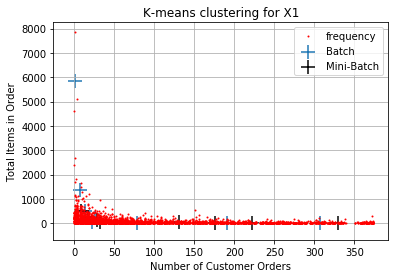

In [48]:
from sklearn.cluster import MiniBatchKMeans


X1 = rfm_data[['recency','frequency']]

# run kmeans algorithm (this is the most traditional use of k-means)
kmeans = KMeans(init='random', # initialization
        n_clusters=8,  # number of clusters
        n_init=1,       # number of different times to run k-means
        n_jobs=-1)
kmeans_mini = MiniBatchKMeans(n_clusters=8, batch_size=10)

kmeans.fit(X1)
kmeans_mini.fit(X1)

# visualize the data
centroids = kmeans.cluster_centers_
plt.plot(X1.iloc[:, 0], X1.iloc[:, 1], 'r.', markersize=2) #plot the data
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, label='Batch')  # plot the centroids

centroids = kmeans_mini.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k',label='Mini-Batch')  # plot the centroids
plt.legend()
plt.title('K-means clustering for X1')
plt.xlabel('Number of Customer Orders')
plt.ylabel('Total Items in Order')
plt.grid()
plt.show()